<a href="https://colab.research.google.com/github/surajsrivathsa/ovgu_deeplearning/blob/master/Introspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Assignment 4:** Introspection

**Team members:**
1. Sanjeeth Busnur Indushekar: 224133 : sanjeeth.busnur@st.ovgu.de
2. Suraj Shashidhar: 230052 : suraj.shashidhar@st.ovgu.de

Tasks To be done

4.1 gradient-based saliency map (sensitivity analysis)

- - Run a batch of inputs through the trained model.

Wrap this in a GradientTape where you watch the input batch.
(batch size can be 1 if you just like to produce a single saliency map)
Compute the gradient for a particular logit or its softmax output with respect to the input.

- This tells us how a change in each input pixel would affect the class output.

- This already gives you a batch of gradient-based saliency maps!

- Plot the saliency map next to the original image or superimpose it.

- Do the saliency maps seem to make sense? How would you interpret them?

Hint: It makes sense to take the sign of the gradient into account when interpreting them.

Negative gradients indicate a decrease in output value, positive gradients an increase.

4.2 Activation Maximization

Extend the code from 4.1 to create an optimal input for a particular class.

- Add the gradients (i.e. the saliency map) to the input. You should multiply the gradients with a small constant (like a learning rate) to make sure the inputs aren’t changed too much.

- Do multiple update steps to make the input more optimal for the chosen output class.
(I recommend implementing your own update step, but you are allowed to use a keras training loop to optimize the input.)

- Does the resulting input look natural?

- How does the inputs change when applying many steps of optimization?

- How do the optimal inputs differ when initializing the optimization with random noise instead of real examples?

Bonus: Apply regularization strategies to make the optimal input more natural-looking.



In [12]:
import os
%tensorflow_version 2.x
import tensorflow as tf
from sklearn import preprocessing
from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import copy
import numpy as np
from datasets import MNISTDataset

In [10]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import initializers
import tensorboard
import time
from datetime import datetime
from keras import backend as K

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
[0 4 1 9 2 1 3 1 4]


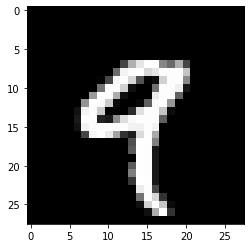

In [13]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
plt.imshow(train_images[4], cmap="Greys_r")
print(train_labels[1:10])

In [14]:
data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)
print(train_images.reshape([-1, 784]).shape)

(60000, 784)


In [15]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [43]:
new_train_images = tf.expand_dims(train_images, axis = -1)
print(new_train_images.shape)

new_test_images = tf.expand_dims(test_images, axis=-1 )
print(new_test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


# Pretrain a simple CNN model

In [44]:
def create_cnn_model():
  model = keras.Sequential()
  model.add(layers.Conv2D(filters=8,kernel_size=(3,3),padding="same",activation="relu" , input_shape=(28, 28, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=16,kernel_size=(3,3),padding="same",activation="relu" ))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
  model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
  model.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
  model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=64,kernel_size=(1,1),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten(input_shape=(3,3,64)))
  model.add(layers.Dense(units=256, activation="relu"))
  model.add(layers.Dense(units=10,activation="softmax"))
  model.summary()
  return model;

In [45]:
vgg_cnn_model = create_cnn_model()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_154 (Conv2D)          (None, 28, 28, 8)         80        
_________________________________________________________________
batch_normalization_110 (Bat (None, 28, 28, 8)         32        
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 28, 28, 16)        1168      
_________________________________________________________________
batch_normalization_111 (Bat (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 14, 14, 32)        4640      
_________________________________________________________________
batch_normalization_112 (Bat (None, 14, 14, 32)      

In [46]:
vgg_cnn_model.compile(optimizer="adam", loss = tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

In [47]:
vgg_cnn_model.fit(new_train_images, train_labels,  epochs=7, batch_size=128, validation_data= (new_test_images, test_labels))

Epoch 1/7
439/469 [===========================>..] - ETA: 35s - loss: 0.1159 - accuracy: 0.9642

KeyboardInterrupt: ignored

# New Section

90112/83281 [================================] - 0s 0us/step


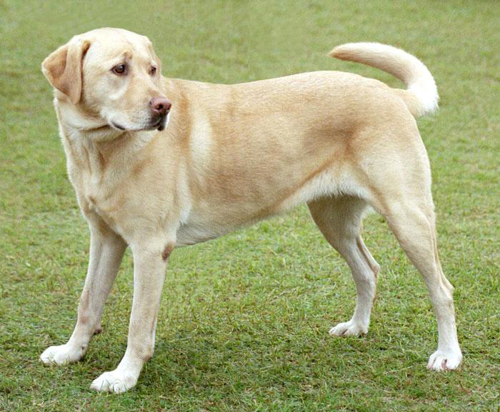

In [3]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

In [4]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87916544/87910968 [==============================] - 4s 0us/step


In [5]:
base_model.layers

In [6]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [7]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)